## Adjustments to iceberg input file to make it consistent with the ACCESS-OM2-01 grid

In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import cartopy.crs as ccrs
import xarray as xr
import cmocean.cm as cmocean
from glob import glob
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.path as mpath
import matplotlib.colors as col
from netCDF4 import Dataset

import xarray as xr
import xesmf as xe

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

#figdir = '/g/data/e14/pc5520/figures/basal_melt_param/'

In [2]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 28,Total memory: 125.20 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38159,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 125.20 GiB
Comm: tcp://127.0.0.1:40397,Total threads: 4
Dashboard: /proxy/35889/status,Memory: 17.89 GiB
Nanny: tcp://127.0.0.1:42097,


In [3]:
master_session = cc.database.create_session()

control = '01deg_jra55v13_ryf9091'

# idem as GPC013 but gade line formulation
Tfreezing_min_calv_2_gade = 'accessom2-GPC015'

start_time='2152-01-01'
end_time='2153-01-01'

lat_slice  = slice(-80,-59)

In [4]:
# build database for these experiments:
session_name = '/g/data/e14/pc5520/model_data/access-om2/basal_melt_MOM5/basal_melt_MOM5.db'
basal_melt_session = cc.database.create_session(session_name)

#dir_list = ['/g/data/e14/pc5520/access-om2/archive/01deg_jra55v13_ryf9091_rerun_for_easterlies/accessom2-GPC013/',
#           '/g/data/ik11/outputs/access-om2-01/basal_melt_outputs/accessom2-GPC015/accessom2-GPC015/']
#cc.database.build_index(dir_list,basal_melt_session)

In [5]:
# topography data for plotting:
ht = cc.querying.getvar(control,'ht' , master_session,n=1)
land_mask = np.squeeze(ht.values)*0
land_mask[np.isnan(land_mask)] = 1
land_mask = np.where(land_mask==1,land_mask,np.nan)
land_mask_masked = np.ma.masked_where((land_mask==0),land_mask)
# make land go all the way to -90S:
land_mask_lat = ht.yt_ocean.values
land_mask_lat[0] = -90

### Blinear regridding of Merino iceberg flux:

In [6]:
# set up dataset to grid onto:
xt_ocean = cc.querying.getvar(control,'xt_ocean' , master_session,n=1)
yt_ocean = cc.querying.getvar(control,'yt_ocean' , master_session,n=1)
grid_out = xr.Dataset({'xt_ocean': xt_ocean,'yt_ocean':yt_ocean})
grid_out = grid_out.rename({"xt_ocean": "lon", "yt_ocean": "lat"})

# original Merino data on NEMO grid:
grid_in = xr.open_dataset("/home/552/pc5520/forcing_files/ICB/Iceberg_Interannual_Merino.nc")
grid_in = grid_in.rename({"longitude": "lon", "latitude": "lat"})

# regrid:
# regrid flux not mass:
regridder = xe.Regridder(grid_in, grid_out, "bilinear")
data_regrided = regridder(grid_in)
Merino_interpolated = data_regrided.Icb_flux

# rename coords, so we can multiply by area later:
Merino_interpolated = Merino_interpolated.rename({"lon": "xt_ocean", "lat": "yt_ocean"})

### Import JRA and compare with bilinear regridded flux:

In [7]:
# import JRA55 RYF calving file:

# Note there is no calving data in JRA55v1.3, but this input has not changed between versions (I think)
JRA_iceberg_file = "/g/data/ik11/inputs/JRA-55/RYF/v1-4/RYF.licalvf.1990_1991.nc"
JRA_RYF_icebergs = xr.open_dataset(JRA_iceberg_file)
JRA_RYF_icebergs = JRA_RYF_icebergs.licalvf

# We want to make sure that the summed flux over 1 year matches (JRA has no seasonal cycle, but Merino does):
# Sum over all days:
JRA_RYF_icebergs = (JRA_RYF_icebergs).sum('time')*24*60*60

# set Greenland flux = 0:
JRA_RYF_icebergs = JRA_RYF_icebergs.where(JRA_RYF_icebergs.lat < 0).fillna(0)
#JRA_RYF_icebergs.plot(cmap=cmocean.amp,vmin=0,vmax=.00001)

# get JRA area variable:
JRA_area_file = '/g/data/qv56/replicas/input4MIPs/CMIP6/OMIP/MRI/MRI-JRA55-do-1-3/landIce/fx/areacellg/gn/v20180412/areacellg_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-1-3_gn.nc'
JRA_area = xr.open_dataset(JRA_area_file)
JRA_area = JRA_area.areacellg

In [8]:
# multiply by area and compare magnitude:

# JRA:
JRA_net_flux = (JRA_RYF_icebergs*JRA_area).sum()
print('JRA flux =',JRA_net_flux.values/1e15,'x 10^15 kg/year')

# Merino interpolated:
# weight by months:
days_in_month = xr.DataArray([31,28,31,30,31,30,31,31,30,31,30,31],coords=dict(month=np.arange(1,13)),dims=['month'])
# make sure we use non-masked area, because some of the fluxes are over land currently:
unmasked_area_file = "/g/data/v45/akm157/model_data/mom01_unmasked_ocean_grid.nc"
ACCESS_area = xr.open_dataset(unmasked_area_file).area_t
ACCESS_area = ACCESS_area.load()

Merino_interp_net_flux = (Merino_interpolated*days_in_month*ACCESS_area).sum()*24*60*60
print('Interpolated Merino flux =',Merino_interp_net_flux.values/1e15,'x 10^15 kg/year')

print('Interpolated flux is',Merino_interp_net_flux.values/JRA_net_flux.values,'times the JRA RYF flux')


JRA flux = 1.314623185747968 x 10^15 kg/year
Interpolated Merino flux = 1.3175656101142326 x 10^15 kg/year
Interpolated flux is 1.002238226434893 times the JRA RYF flux


### Also compare with Pedro's JRA flux interpolated onto the ACCESS-OM2-01 grid:

In [24]:
JRA_interp_file = "/home/552/pc5520/forcing_files/ocean_month_output_GPC010_calving_365_final.nc"
JRA_interp_icebergs = xr.open_dataset(JRA_interp_file,decode_times=False)
JRA_interp_icebergs = JRA_interp_icebergs.calving
# rename coords so we can multiply them:
JRA_interp_icebergs.coords['lat'] = ACCESS_area['yt_ocean'].values
JRA_interp_icebergs.coords['lon'] = ACCESS_area['xt_ocean'].values
JRA_interp_icebergs = JRA_interp_icebergs.rename(({'lon':'xt_ocean', 'lat':'yt_ocean'}))

# weight by months:
# Make sure time coord matches JRA interpolated file:
days_in_month = xr.DataArray([31,28,31,30,31,30,31,31,30,31,30,31],coords=dict(time=JRA_interp_icebergs.time.values),dims=['time'])
JRA_interp_net_flux = (JRA_interp_icebergs*days_in_month*ACCESS_area).sum()*24*60*60
print('Interpolated JRA flux =',JRA_interp_net_flux.values/1e15,'x 10^15 kg/year')

# Interesting, this doesn't quite match the original JRA flux. So let's scale to this one instead.

Interpolated Merino flux = 1.3188671560858565 x 10^15 kg/year


### Check is any of the regridded flux is on land in ACCESS-OM2-01:

In [25]:
# We need to shift mass (kg/s) not fluxes (kg/s/m^2).

Merino_interp_mass = Merino_interpolated*ACCESS_area

# Then divide again by area at the end.

In [26]:
# create land mask:
ht = cc.querying.getvar(control,'ht' , master_session,n=1)
ocean_mask = (ht*0+1).fillna(0)
ocean_mask = ocean_mask.load()

# mask everything except fluxes on land:
flux_on_land = Merino_interp_mass.where(ocean_mask==0).fillna(0)

number_on_land = flux_on_land.where(flux_on_land>0).count()
print(number_on_land.values,'cells on land have non-zero flux')

92007 cells on land have non-zero flux


In [27]:
# Now shift the land fluxes north by 1 - add flux now over the ocean to array 'shifted_land_fluxes' and substract from array 'flux_on_land'
# KDTree would be a better way to do this.

# shift one cell to north:
flux_on_land_shift = flux_on_land.roll(yt_ocean=1)
# mask land:
flux_on_land_shift = flux_on_land_shift.where(ocean_mask==1).fillna(0)
# add these shifted values to new array:
shifted_land_fluxes = Merino_interp_mass*0 + flux_on_land_shift
# shift these values back to their original positions and subtract from flux_on_land:
flux_on_land_shift = flux_on_land_shift.roll(yt_ocean=-1)
flux_on_land -= flux_on_land_shift

number_on_land = flux_on_land.where(flux_on_land>0).count()
print(number_on_land.values,'cells on land have non-zero flux')

# Note that the following shifts don't all follow north, south, east, west for all shift values, because some of them did nothing, so I deleted them.

65752 cells on land have non-zero flux


In [28]:
# Repeat shifting east instead of north:

# shift one cell to east:
flux_on_land_shift = flux_on_land.roll(xt_ocean=1)
# mask land:
flux_on_land_shift = flux_on_land_shift.where(ocean_mask==1).fillna(0)
# add these shifted values to new array:
shifted_land_fluxes += flux_on_land_shift
# shift these values back to their original positions and subtract from flux_on_land:
flux_on_land_shift = flux_on_land_shift.roll(xt_ocean=-1)
flux_on_land -= flux_on_land_shift

number_on_land = flux_on_land.where(flux_on_land>0).count()
print(number_on_land.values,'cells on land have non-zero flux')

60610 cells on land have non-zero flux


In [29]:
# Repeat shifting west:

# shift one cell to west:
flux_on_land_shift = flux_on_land.roll(xt_ocean=-1)
# mask land:
flux_on_land_shift = flux_on_land_shift.where(ocean_mask==1).fillna(0)
# add these shifted values to new array:
shifted_land_fluxes += flux_on_land_shift
# shift these values back to their original positions and subtract from flux_on_land:
flux_on_land_shift = flux_on_land_shift.roll(xt_ocean=1)
flux_on_land -= flux_on_land_shift

number_on_land = flux_on_land.where(flux_on_land>0).count()
print(number_on_land.values,'cells on land have non-zero flux')

55531 cells on land have non-zero flux


In [30]:
# shift 2 cells to north:
flux_on_land_shift = flux_on_land.roll(yt_ocean=2)
# mask land:
flux_on_land_shift = flux_on_land_shift.where(ocean_mask==1).fillna(0)
# add these shifted values to new array:
shifted_land_fluxes += flux_on_land_shift
# shift these values back to their original positions and subtract from flux_on_land:
flux_on_land_shift = flux_on_land_shift.roll(yt_ocean=-2)
flux_on_land -= flux_on_land_shift

number_on_land = flux_on_land.where(flux_on_land>0).count()
print(number_on_land.values,'cells on land have non-zero flux')

42985 cells on land have non-zero flux


In [31]:
# shift 2 cells to west:
flux_on_land_shift = flux_on_land.roll(xt_ocean=-2)
# mask land:
flux_on_land_shift = flux_on_land_shift.where(ocean_mask==1).fillna(0)
# add these shifted values to new array:
shifted_land_fluxes += flux_on_land_shift
# shift these values back to their original positions and subtract from flux_on_land:
flux_on_land_shift = flux_on_land_shift.roll(xt_ocean=2)
flux_on_land -= flux_on_land_shift

number_on_land = flux_on_land.where(flux_on_land>0).count()
print(number_on_land.values,'cells on land have non-zero flux')

39825 cells on land have non-zero flux


In [32]:
# shift 2 cells to south:
flux_on_land_shift = flux_on_land.roll(yt_ocean=-2)
# mask land:
flux_on_land_shift = flux_on_land_shift.where(ocean_mask==1).fillna(0)
# add these shifted values to new array:
shifted_land_fluxes += flux_on_land_shift
# shift these values back to their original positions and subtract from flux_on_land:
flux_on_land_shift = flux_on_land_shift.roll(yt_ocean=2)
flux_on_land -= flux_on_land_shift

number_on_land = flux_on_land.where(flux_on_land>0).count()
print(number_on_land.values,'cells on land have non-zero flux')

38240 cells on land have non-zero flux


In [33]:
# Get a bit more dramatic now - doesn't matter too much if not right on coastal grid cell:

# shift 5 cells to north:
flux_on_land_shift = flux_on_land.roll(yt_ocean=5)
# mask land:
flux_on_land_shift = flux_on_land_shift.where(ocean_mask==1).fillna(0)
# add these shifted values to new array:
shifted_land_fluxes += flux_on_land_shift
# shift these values back to their original positions and subtract from flux_on_land:
flux_on_land_shift = flux_on_land_shift.roll(yt_ocean=-5)
flux_on_land -= flux_on_land_shift

number_on_land = flux_on_land.where(flux_on_land>0).count()
print(number_on_land.values,'cells on land have non-zero flux')

22187 cells on land have non-zero flux


In [34]:
# shift 5 cells to south:
flux_on_land_shift = flux_on_land.roll(yt_ocean=-5)
# mask land:
flux_on_land_shift = flux_on_land_shift.where(ocean_mask==1).fillna(0)
# add these shifted values to new array:
shifted_land_fluxes += flux_on_land_shift
# shift these values back to their original positions and subtract from flux_on_land:
flux_on_land_shift = flux_on_land_shift.roll(yt_ocean=5)
flux_on_land -= flux_on_land_shift

number_on_land = flux_on_land.where(flux_on_land>0).count()
print(number_on_land.values,'cells on land have non-zero flux')

20959 cells on land have non-zero flux


In [35]:
# shift 5 cells to east:
flux_on_land_shift = flux_on_land.roll(xt_ocean=5)
# mask land:
flux_on_land_shift = flux_on_land_shift.where(ocean_mask==1).fillna(0)
# add these shifted values to new array:
shifted_land_fluxes += flux_on_land_shift
# shift these values back to their original positions and subtract from flux_on_land:
flux_on_land_shift = flux_on_land_shift.roll(xt_ocean=-5)
flux_on_land -= flux_on_land_shift

number_on_land = flux_on_land.where(flux_on_land>0).count()
print(number_on_land.values,'cells on land have non-zero flux')

18231 cells on land have non-zero flux


In [36]:
# shift 5 cells to west:
flux_on_land_shift = flux_on_land.roll(xt_ocean=-5)
# mask land:
flux_on_land_shift = flux_on_land_shift.where(ocean_mask==1).fillna(0)
# add these shifted values to new array:
shifted_land_fluxes += flux_on_land_shift
# shift these values back to their original positions and subtract from flux_on_land:
flux_on_land_shift = flux_on_land_shift.roll(xt_ocean=5)
flux_on_land -= flux_on_land_shift

number_on_land = flux_on_land.where(flux_on_land>0).count()
print(number_on_land.values,'cells on land have non-zero flux')

15983 cells on land have non-zero flux


In [37]:
# More dramatic again - doesn't matter too much if not right on coastal grid cell:

# shift 10 cells to north:
flux_on_land_shift = flux_on_land.roll(yt_ocean=10)
# mask land:
flux_on_land_shift = flux_on_land_shift.where(ocean_mask==1).fillna(0)
# add these shifted values to new array:
shifted_land_fluxes += flux_on_land_shift
# shift these values back to their original positions and subtract from flux_on_land:
flux_on_land_shift = flux_on_land_shift.roll(yt_ocean=-10)
flux_on_land -= flux_on_land_shift

number_on_land = flux_on_land.where(flux_on_land>0).count()
print(number_on_land.values,'cells on land have non-zero flux')

8150 cells on land have non-zero flux


In [38]:
# shift 10 cells to east:
flux_on_land_shift = flux_on_land.roll(xt_ocean=10)
# mask land:
flux_on_land_shift = flux_on_land_shift.where(ocean_mask==1).fillna(0)
# add these shifted values to new array:
shifted_land_fluxes += flux_on_land_shift
# shift these values back to their original positions and subtract from flux_on_land:
flux_on_land_shift = flux_on_land_shift.roll(xt_ocean=-10)
flux_on_land -= flux_on_land_shift

number_on_land = flux_on_land.where(flux_on_land>0).count()
print(number_on_land.values,'cells on land have non-zero flux')

7414 cells on land have non-zero flux


In [39]:
# shift 10 cells to west:
flux_on_land_shift = flux_on_land.roll(xt_ocean=-10)
# mask land:
flux_on_land_shift = flux_on_land_shift.where(ocean_mask==1).fillna(0)
# add these shifted values to new array:
shifted_land_fluxes += flux_on_land_shift
# shift these values back to their original positions and subtract from flux_on_land:
flux_on_land_shift = flux_on_land_shift.roll(xt_ocean=10)
flux_on_land -= flux_on_land_shift

number_on_land = flux_on_land.where(flux_on_land>0).count()
print(number_on_land.values,'cells on land have non-zero flux')

5116 cells on land have non-zero flux


In [40]:
# Even More dramatic again - doesn't matter too much if not right on coastal grid cell:

# shift 20 cells to north:
flux_on_land_shift = flux_on_land.roll(yt_ocean=20)
# mask land:
flux_on_land_shift = flux_on_land_shift.where(ocean_mask==1).fillna(0)
# add these shifted values to new array:
shifted_land_fluxes += flux_on_land_shift
# shift these values back to their original positions and subtract from flux_on_land:
flux_on_land_shift = flux_on_land_shift.roll(yt_ocean=-20)
flux_on_land -= flux_on_land_shift

number_on_land = flux_on_land.where(flux_on_land>0).count()
print(number_on_land.values,'cells on land have non-zero flux')

2361 cells on land have non-zero flux


In [41]:
# shift 20 cells to west:
flux_on_land_shift = flux_on_land.roll(xt_ocean=-20)
# mask land:
flux_on_land_shift = flux_on_land_shift.where(ocean_mask==1).fillna(0)
# add these shifted values to new array:
shifted_land_fluxes += flux_on_land_shift
# shift these values back to their original positions and subtract from flux_on_land:
flux_on_land_shift = flux_on_land_shift.roll(xt_ocean=20)
flux_on_land -= flux_on_land_shift

number_on_land = flux_on_land.where(flux_on_land>0).count()
print(number_on_land.values,'cells on land have non-zero flux')

1419 cells on land have non-zero flux


In [42]:
# shift 20 cells to east:
flux_on_land_shift = flux_on_land.roll(xt_ocean=20)
# mask land:
flux_on_land_shift = flux_on_land_shift.where(ocean_mask==1).fillna(0)
# add these shifted values to new array:
shifted_land_fluxes += flux_on_land_shift
# shift these values back to their original positions and subtract from flux_on_land:
flux_on_land_shift = flux_on_land_shift.roll(xt_ocean=-20)
flux_on_land -= flux_on_land_shift

number_on_land = flux_on_land.where(flux_on_land>0).count()
print(number_on_land.values,'cells on land have non-zero flux')

1397 cells on land have non-zero flux


In [43]:
# Even More dramatic again - doesn't matter too much if not right on coastal grid cell:

# shift 40 cells to north:
flux_on_land_shift = flux_on_land.roll(yt_ocean=40)
# mask land:
flux_on_land_shift = flux_on_land_shift.where(ocean_mask==1).fillna(0)
# add these shifted values to new array:
shifted_land_fluxes += flux_on_land_shift
# shift these values back to their original positions and subtract from flux_on_land:
flux_on_land_shift = flux_on_land_shift.roll(yt_ocean=-40)
flux_on_land -= flux_on_land_shift

number_on_land = flux_on_land.where(flux_on_land>0).count()
print(number_on_land.values,'cells on land have non-zero flux')

213 cells on land have non-zero flux


In [44]:
# shift 40 cells to west:
flux_on_land_shift = flux_on_land.roll(xt_ocean=-40)
# mask land:
flux_on_land_shift = flux_on_land_shift.where(ocean_mask==1).fillna(0)
# add these shifted values to new array:
shifted_land_fluxes += flux_on_land_shift
# shift these values back to their original positions and subtract from flux_on_land:
flux_on_land_shift = flux_on_land_shift.roll(xt_ocean=40)
flux_on_land -= flux_on_land_shift

number_on_land = flux_on_land.where(flux_on_land>0).count()
print(number_on_land.values,'cells on land have non-zero flux')

0 cells on land have non-zero flux


(-80.0, -50.0)

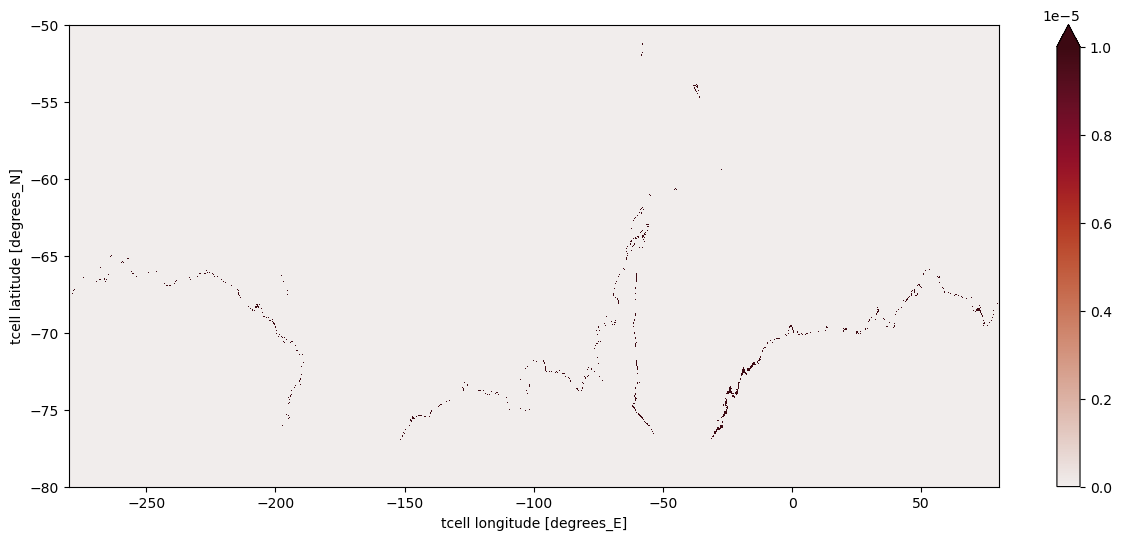

In [45]:
plt.figure(figsize=(15,6))
shifted_land_fluxes.sum('month').plot(cmap=cmocean.amp,vmin=0,vmax=.00001)
plt.ylim(-80,-50)

In [50]:
# Add to original array, and check sums

Merino_interp_on_ocean_mass = Merino_interp_mass.where(ocean_mask==1).fillna(0) + shifted_land_fluxes
Merino_interp_on_ocean_mass = Merino_interp_on_ocean_mass.load()

# Convert back to (kg/s/m^2):
Merino_interp_on_ocean = Merino_interp_on_ocean_mass/ACCESS_area

#plt.figure(figsize=(15,6))
#Merino_interp_on_ocean.sum('month').plot(cmap=cmocean.amp,vmin=0,vmax=.00001)
#plt.ylim(-80,-50)

### multiply by area and compare magnitude:

# JRA:
print('JRA flux =',JRA_net_flux.values/1e15,'x 10^15 kg/s')
print('Interpolated JRA flux =',JRA_interp_net_flux.values/1e15,'x 10^15 kg/year')

# Merino original interpolated:
# weight by months:
days_in_month = xr.DataArray([31,28,31,30,31,30,31,31,30,31,30,31],coords=dict(month=np.arange(1,13)),dims=['month'])
Merino_interp_net_flux = (Merino_interpolated*days_in_month*ACCESS_area).sum()*24*60*60
print('Interpolated Merino flux =',Merino_interp_net_flux.values/1e15,'x 10^15 kg/year')

# with fluxes shifted off land:
Merino_interp_on_ocean_net_flux = (Merino_interp_on_ocean*days_in_month*ACCESS_area).sum()*24*60*60
print('Interpolated Merino flux shifted over ocean =',Merino_interp_on_ocean_net_flux.values/1e15,'x 10^15 kg/year')

print('Interpolated flux is',Merino_interp_net_flux.values/JRA_net_flux.values,'times the JRA RYF flux')
print('Interpolated flux shifted over ocean is',Merino_interp_on_ocean_net_flux.values/JRA_net_flux.values,'times the JRA RYF flux')

JRA flux = 1.314623185747968 x 10^15 kg/s
Interpolated JRA flux = 1.3188671560858565 x 10^15 kg/year
Interpolated Merino flux = 1.3175656101142326 x 10^15 kg/year
Interpolated Merino flux shifted over ocean = 1.317565610108888 x 10^15 kg/year
Interpolated flux is 1.002238226434893 times the JRA RYF flux
Interpolated flux shifted over ocean is 1.0022382264308276 times the JRA RYF flux


### Now ensure no gaps between iceberg flux and coast (because NEMO grid ends further north than ACCESS)

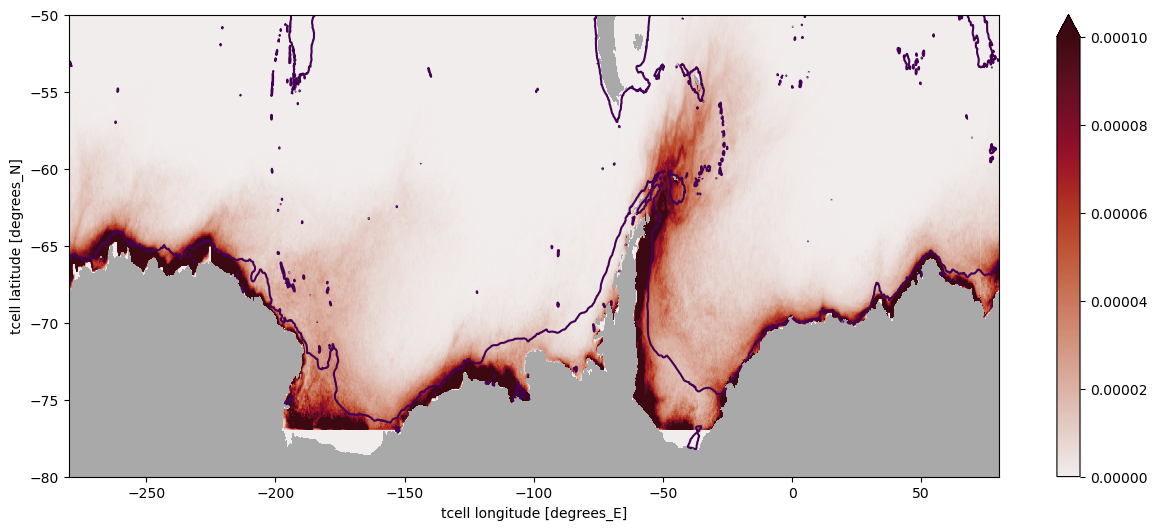

In [51]:
plt.figure(figsize=(15,6))
Merino_interp_on_ocean.sum('month').plot(cmap=cmocean.amp,vmin=0,vmax=.0001)
plt.ylim(-80,-50)

plt.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',zorder=2)
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000])

In [52]:
# Interpolate mass (kg/s) further south in Weddell Sea:
Weddell_southern_fluxes = np.copy(Merino_interp_on_ocean_mass)*0

# slice ocean_mask to make this faster:
ocean_mask = ocean_mask.sel(yt_ocean=slice(-82,-75))

def interp1d(array: np.ndarray, new_len: int) -> np.ndarray:
    la = len(array)
    return np.interp(np.linspace(0, la - 1, num=new_len), np.arange(la), array)
    
lon_range_Weddell = ht.xt_ocean.sel(xt_ocean=slice(-53,-31))
    
for lon in lon_range_Weddell:
    lon = lon.values
    #print('lon =',lon)
    
    for month_id in range(12):
        #print('month =',month_id)
        
        flux_this_lon_shelf = Merino_interp_on_ocean_mass.sel(month=month_id).sel(yt_ocean=slice(-82,-75)).sel(xt_ocean=lon,method='nearest')
        if flux_this_lon_shelf.max() == 0:
            break
        
        if month_id == 0:
            
            # find region we want to stretch flux over:
            new_shelf_region = ocean_mask.sel(xt_ocean=lon,method='nearest')
            # find first ocean index and cut south of there:
            first_ocean_index = np.where(new_shelf_region>0)[0][0]
            new_shelf_region = new_shelf_region[first_ocean_index:]
            #.where(ocean_mask.sel(xt_ocean=lon,method='nearest')>0,drop=True)#.where(flux_this_lon_shelf>-1,drop=True)

            min_y_value = np.where(Merino_interp_on_ocean_mass.yt_ocean == new_shelf_region.yt_ocean[0])[0][0]
            max_y_value = np.where(Merino_interp_on_ocean_mass.yt_ocean == new_shelf_region.yt_ocean[-1])[0][0]
            x_value = np.where(Merino_interp_on_ocean_mass.xt_ocean == flux_this_lon_shelf.xt_ocean)[0][0]
            
        # first check if this longitude needs interpolation:
        if flux_this_lon_shelf[min_y_value] == 0:
    
            stretched_flux_array = interp1d(flux_this_lon_shelf.where(flux_this_lon_shelf>0,drop=True).values, new_len=len(new_shelf_region))

            # rescale so mass fluxes match:
            sum_old_fluxes = flux_this_lon_shelf.sum().values
            sum_new_fluxes = stretched_flux_array.sum()

            Weddell_southern_fluxes[month_id,min_y_value:max_y_value+1,x_value] = stretched_flux_array/sum_new_fluxes*sum_old_fluxes

In [53]:
# Interpolate mass (kg/s) further south in Ross Sea:
Ross_southern_fluxes = np.copy(Merino_interp_on_ocean_mass)*0

# slice ocean_mask to make this faster:
ocean_mask = ocean_mask.sel(yt_ocean=slice(-82,-75))

def interp1d(array: np.ndarray, new_len: int) -> np.ndarray:
    la = len(array)
    return np.interp(np.linspace(0, la - 1, num=new_len), np.arange(la), array)
    
lon_range_Ross = ht.xt_ocean.sel(xt_ocean=slice(-197,-150))
    
for lon in lon_range_Ross:
    lon = lon.values
    #print('lon =',lon)
    
    for month_id in range(12):
        #print('month =',month_id)
        
        flux_this_lon_shelf = Merino_interp_on_ocean_mass.sel(month=month_id).sel(yt_ocean=slice(-82,-75)).sel(xt_ocean=lon,method='nearest')
        if flux_this_lon_shelf.max() == 0:
            break
        
        if month_id == 0:
            
            # find region we want to stretch flux over:
            new_shelf_region = ocean_mask.sel(xt_ocean=lon,method='nearest')
            # find first ocean index and cut south of there:
            first_ocean_index = np.where(new_shelf_region>0)[0][0]
            new_shelf_region = new_shelf_region[first_ocean_index:]
            #.where(ocean_mask.sel(xt_ocean=lon,method='nearest')>0,drop=True)#.where(flux_this_lon_shelf>-1,drop=True)

            min_y_value = np.where(Merino_interp_on_ocean_mass.yt_ocean == new_shelf_region.yt_ocean[0])[0][0]
            max_y_value = np.where(Merino_interp_on_ocean_mass.yt_ocean == new_shelf_region.yt_ocean[-1])[0][0]
            x_value = np.where(Merino_interp_on_ocean_mass.xt_ocean == flux_this_lon_shelf.xt_ocean)[0][0]
            
        # first check if this longitude needs interpolation:
        if flux_this_lon_shelf[min_y_value] == 0:
    
            stretched_flux_array = interp1d(flux_this_lon_shelf.where(flux_this_lon_shelf>0,drop=True).values, new_len=len(new_shelf_region))

            # rescale so mass fluxes match:
            sum_old_fluxes = flux_this_lon_shelf.sum().values
            sum_new_fluxes = stretched_flux_array.sum()

            Ross_southern_fluxes[month_id,min_y_value:max_y_value+1,x_value] = stretched_flux_array/sum_new_fluxes*sum_old_fluxes

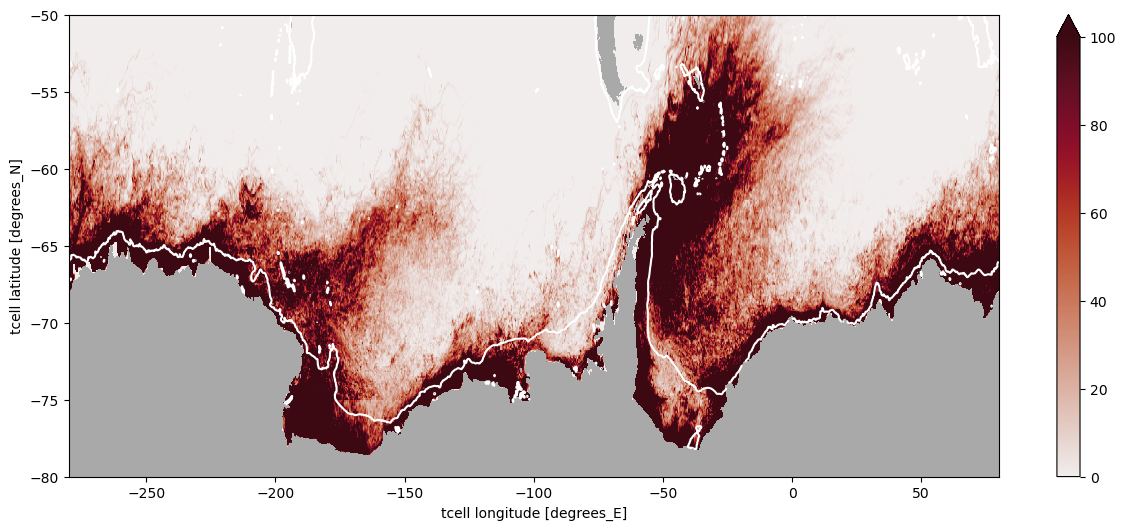

In [54]:
# Overwrite these regions in the full iceberg flux array:

# give the arrays coords etc:
Ross_southern_mass = Merino_interp_on_ocean_mass.copy()*0
Ross_southern_mass[...] = Ross_southern_fluxes

Weddell_southern_mass = Merino_interp_on_ocean_mass.copy()*0
Weddell_southern_mass[...] = Weddell_southern_fluxes

# set these values to zero in original array and add new fluxes:
Merino_interp_extend_Ross_Weddell = Merino_interp_on_ocean_mass.where(Weddell_southern_mass==0,other=0)
Merino_interp_extend_Ross_Weddell += Weddell_southern_mass

Merino_interp_extend_Ross_Weddell = Merino_interp_extend_Ross_Weddell.where(Ross_southern_mass==0,other=0)
Merino_interp_extend_Ross_Weddell += Ross_southern_mass

plt.figure(figsize=(15,6))
Merino_interp_extend_Ross_Weddell.sel(month = 0).plot(cmap=cmocean.amp,vmin=0,vmax=100)
plt.ylim(-80,-50)
plt.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',zorder=2)
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000],colors='w')

In [55]:
# Check how sum of values compare:

new_flux_sum = Merino_interp_extend_Ross_Weddell.sum()
print('New flux sum =',new_flux_sum.values/1e8)

old_flux_sum = Merino_interp_on_ocean_mass.sum()
print('Old flux sum =',old_flux_sum.values/1e8)

New flux sum = 5.04871968
Old flux sum = 5.04871968


### Check if any fluxes on land again, and move to ocean again:

In [56]:
# create full domain land mask again:
ht = cc.querying.getvar(control,'ht' , master_session,n=1)
ocean_mask = (ht*0+1).fillna(0)
ocean_mask = ocean_mask.load()

# mask everything except fluxes on land:
flux_on_land = Merino_interp_extend_Ross_Weddell.where(ocean_mask==0).fillna(0)

number_on_land = flux_on_land.where(flux_on_land>0).count()
print(number_on_land.values,'cells on land have non-zero flux')

2317 cells on land have non-zero flux


In [57]:
# Now shift the land fluxes north by 2 - add flux now over the ocean to array 'shifted_land_fluxes' and substract from array 'flux_on_land'
# KDTree would be a better way to do this.

# shift one cell to north:
flux_on_land_shift = flux_on_land.roll(yt_ocean=2)
# mask land:
flux_on_land_shift = flux_on_land_shift.where(ocean_mask==1).fillna(0)
# add these shifted values to new array:
shifted_land_fluxes = Merino_interp_extend_Ross_Weddell*0 + flux_on_land_shift
# shift these values back to their original positions and subtract from flux_on_land:
flux_on_land_shift = flux_on_land_shift.roll(yt_ocean=-2)
flux_on_land -= flux_on_land_shift

number_on_land = flux_on_land.where(flux_on_land>0).count()
print(number_on_land.values,'cells on land have non-zero flux')

# Note that the following shifts don't all follow north, south, east, west for all shift values, because some of them did nothing, so I deleted them.

1176 cells on land have non-zero flux


In [58]:
# shift 2 cells to west:
flux_on_land_shift = flux_on_land.roll(xt_ocean=-2)
# mask land:
flux_on_land_shift = flux_on_land_shift.where(ocean_mask==1).fillna(0)
# add these shifted values to new array:
shifted_land_fluxes += flux_on_land_shift
# shift these values back to their original positions and subtract from flux_on_land:
flux_on_land_shift = flux_on_land_shift.roll(xt_ocean=2)
flux_on_land -= flux_on_land_shift

number_on_land = flux_on_land.where(flux_on_land>0).count()
print(number_on_land.values,'cells on land have non-zero flux')

708 cells on land have non-zero flux


In [59]:
# shift 2 cells to east:
flux_on_land_shift = flux_on_land.roll(xt_ocean=2)
# mask land:
flux_on_land_shift = flux_on_land_shift.where(ocean_mask==1).fillna(0)
# add these shifted values to new array:
shifted_land_fluxes += flux_on_land_shift
# shift these values back to their original positions and subtract from flux_on_land:
flux_on_land_shift = flux_on_land_shift.roll(xt_ocean=-2)
flux_on_land -= flux_on_land_shift

number_on_land = flux_on_land.where(flux_on_land>0).count()
print(number_on_land.values,'cells on land have non-zero flux')

648 cells on land have non-zero flux


In [60]:
# shift 2 cells to south:
flux_on_land_shift = flux_on_land.roll(yt_ocean=-2)
# mask land:
flux_on_land_shift = flux_on_land_shift.where(ocean_mask==1).fillna(0)
# add these shifted values to new array:
shifted_land_fluxes += flux_on_land_shift
# shift these values back to their original positions and subtract from flux_on_land:
flux_on_land_shift = flux_on_land_shift.roll(yt_ocean=2)
flux_on_land -= flux_on_land_shift

number_on_land = flux_on_land.where(flux_on_land>0).count()
print(number_on_land.values,'cells on land have non-zero flux')

168 cells on land have non-zero flux


In [61]:
# Get a bit more dramatic now - doesn't matter too much if not right on coastal grid cell:

# shift 5 cells to north:
flux_on_land_shift = flux_on_land.roll(yt_ocean=5)
# mask land:
flux_on_land_shift = flux_on_land_shift.where(ocean_mask==1).fillna(0)
# add these shifted values to new array:
shifted_land_fluxes += flux_on_land_shift
# shift these values back to their original positions and subtract from flux_on_land:
flux_on_land_shift = flux_on_land_shift.roll(yt_ocean=-5)
flux_on_land -= flux_on_land_shift

number_on_land = flux_on_land.where(flux_on_land>0).count()
print(number_on_land.values,'cells on land have non-zero flux')

132 cells on land have non-zero flux


In [62]:
# shift 5 cells to south:
flux_on_land_shift = flux_on_land.roll(yt_ocean=-5)
# mask land:
flux_on_land_shift = flux_on_land_shift.where(ocean_mask==1).fillna(0)
# add these shifted values to new array:
shifted_land_fluxes += flux_on_land_shift
# shift these values back to their original positions and subtract from flux_on_land:
flux_on_land_shift = flux_on_land_shift.roll(yt_ocean=5)
flux_on_land -= flux_on_land_shift

number_on_land = flux_on_land.where(flux_on_land>0).count()
print(number_on_land.values,'cells on land have non-zero flux')

36 cells on land have non-zero flux


In [63]:
# shift 5 cells to west:
flux_on_land_shift = flux_on_land.roll(xt_ocean=-5)
# mask land:
flux_on_land_shift = flux_on_land_shift.where(ocean_mask==1).fillna(0)
# add these shifted values to new array:
shifted_land_fluxes += flux_on_land_shift
# shift these values back to their original positions and subtract from flux_on_land:
flux_on_land_shift = flux_on_land_shift.roll(xt_ocean=5)
flux_on_land -= flux_on_land_shift

number_on_land = flux_on_land.where(flux_on_land>0).count()
print(number_on_land.values,'cells on land have non-zero flux')

0 cells on land have non-zero flux


In [64]:
# Add to original array, and check sums

Merino_interp_extend_Ross_Weddell_mass = Merino_interp_extend_Ross_Weddell.where(ocean_mask==1).fillna(0) + shifted_land_fluxes
Merino_interp_extend_Ross_Weddell_mass = Merino_interp_extend_Ross_Weddell_mass.load()

# Convert back to (kg/s/m^2):
Merino_interp_extend_Ross_Weddell_flux = Merino_interp_extend_Ross_Weddell_mass/ACCESS_area

#plt.figure(figsize=(15,6))
#Merino_interp_on_ocean.sum('month').plot(cmap=cmocean.amp,vmin=0,vmax=.00001)
#plt.ylim(-80,-50)

### multiply by area and compare magnitude:

# JRA:
print('JRA flux =',JRA_net_flux.values/1e15,'x 10^15 kg/s')
print('Interpolated JRA flux =',JRA_interp_net_flux.values/1e15,'x 10^15 kg/year')

# Merino original interpolated:
# weight by months:
days_in_month = xr.DataArray([31,28,31,30,31,30,31,31,30,31,30,31],coords=dict(month=np.arange(1,13)),dims=['month'])
Merino_interp_net_flux = (Merino_interpolated*days_in_month*ACCESS_area).sum()*24*60*60
print('Interpolated Merino flux =',Merino_interp_net_flux.values/1e15,'x 10^15 kg/s')

# with fluxes shifted off land and Ross/Weddell extensions:
Merino_interp_on_ocean_net_flux = (Merino_interp_extend_Ross_Weddell_flux*days_in_month*ACCESS_area).sum()*24*60*60
print('Final adjusted iceberg flux array =',Merino_interp_on_ocean_net_flux.values/1e15,'x 10^15 kg/s')

print('Interpolated flux is',Merino_interp_net_flux.values/JRA_net_flux.values,'times the JRA RYF flux')
print('Final adjusted array is',Merino_interp_on_ocean_net_flux.values/JRA_net_flux.values,'times the JRA RYF flux')

JRA flux = 1.314623185747968 x 10^15 kg/s
Interpolated JRA flux = 1.3188671560858565 x 10^15 kg/year
Interpolated Merino flux = 1.3175656101142326 x 10^15 kg/s
Final adjusted iceberg flux array = 1.3175656101197848 x 10^15 kg/s
Interpolated flux is 1.002238226434893 times the JRA RYF flux
Final adjusted array is 1.0022382264391165 times the JRA RYF flux


### Scale so the sum matches exactly the interpolated JRA flux:

In [65]:
iceberg_input_adjusted = Merino_interp_extend_Ross_Weddell_flux*(JRA_interp_net_flux.values)/(Merino_interp_on_ocean_net_flux.values)

ds = xr.Dataset({'iceberg_input_adjusted': iceberg_input_adjusted})
outpath = '/g/data/v45/akm157/model_data/Nacho_iceberg_fluxes/Merino_adjusted_fluxes.nc'
ds.to_netcdf(outpath)

(-80.0, -50.0)

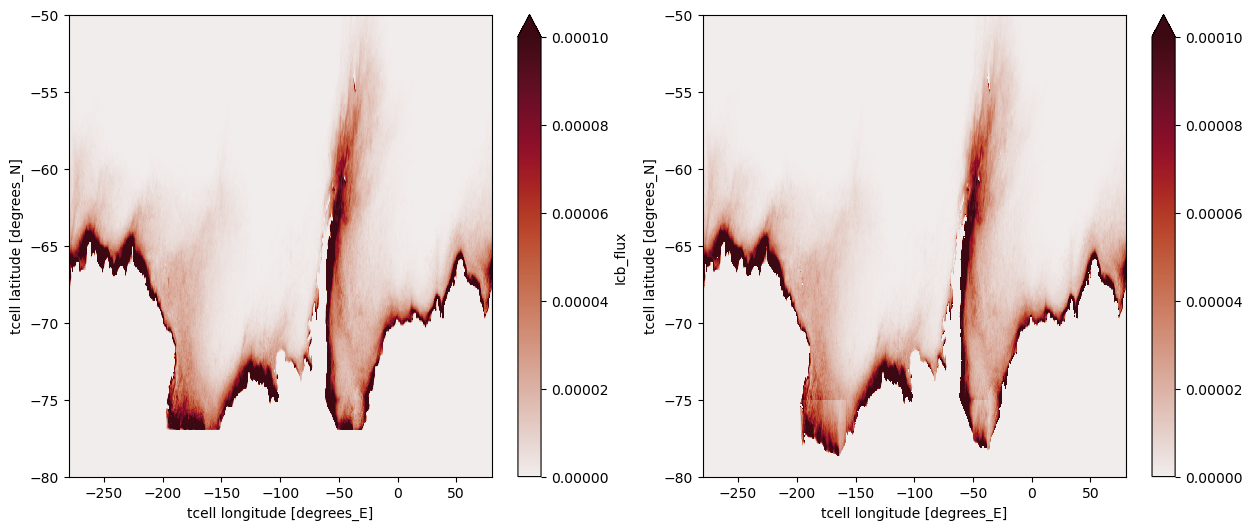

In [66]:

plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
Merino_interpolated.sum('month').plot(cmap=cmocean.amp,vmin=0,vmax=.0001)
plt.ylim(-80,-50)

plt.subplot(1,2,2)
iceberg_input_adjusted.sum('month').plot(cmap=cmocean.amp,vmin=0,vmax=.0001)
#iceberg_input_adjusted.sum('month').plot(cmap=cmocean.amp,vmin=0,vmax=.0001)
plt.ylim(-80,-50)

In [68]:
iceberg_input_adjusted_net_flux = (iceberg_input_adjusted*days_in_month*ACCESS_area).sum()*24*60*60
print('Final interpolated Merino flux =',iceberg_input_adjusted_net_flux.values/1e15,'x 10^15 kg/year')


Final interpolated Merino flux = 1.31886711942882 x 10^15 kg/year
